In [1]:
from model_functions import *

In [34]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [35]:
images = load_dataset('Abhijit85/InsuranceClaimImages')
images = images['train']
n_len = len(images)

# Image visualization

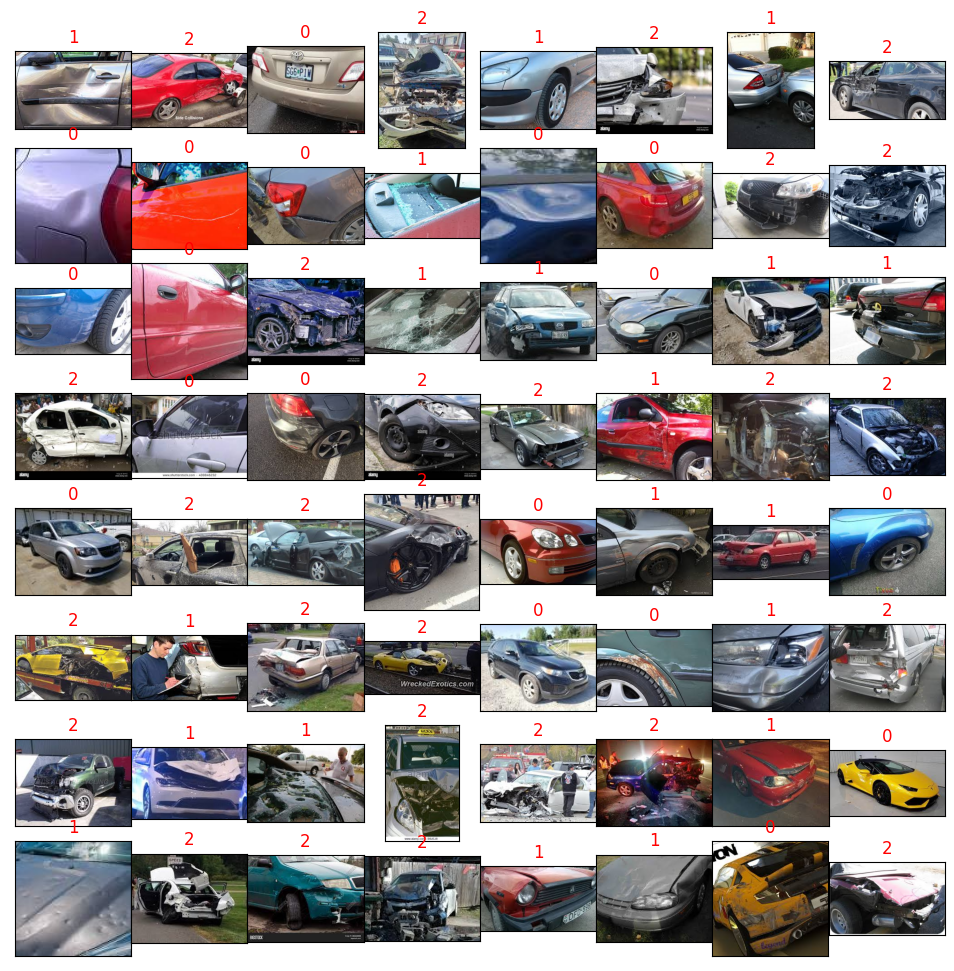

In [64]:
def plot_image_batch(tensor_image, labels, size=8, figsize=(12, 12)):
    rdn_idx = random.sample(range(len(tensor_image)), size * size)
    imgs = [tensor_image[i] for i in rdn_idx]
    titles = [labels[i] for i in rdn_idx]

    fig, ax = plt.subplots(size, size, figsize=figsize) 
    if isinstance(ax, np.ndarray):
        list_axes = list(ax.flat)
    else:
        list_axes = [ax]   
    for index, img in enumerate(imgs):
        list_axes[index].set_xticks([])
        list_axes[index].set_yticks([])
        list_axes[index].set_title(titles[index], color='red')
        list_axes[index].imshow(img.permute(1, 2, 0))
    plt.subplots_adjust(wspace=0, hspace=0)    
    plt.show()

img_tranformed = []
for image in images['image']:
    img_tranformed.append(pil_to_tensor(image))
labels = images['label']    
plot_image_batch(img_tranformed, labels, 8) 

# Data preprocessing

In [4]:
train_size = int(0.8 * n_len) # Selecting 80% of data for training
batch_size = 20  # batch size

# Create train and test datasets
data = images.train_test_split(test_size=0.2)
data["train"].set_transform(transform_fly)
data["test"].set_transform(transform_test_data)
train_loader = DataLoader(dataset=data["train"], collate_fn=collate_fn, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=data["test"], collate_fn=collate_fn, shuffle =True)    


# Transfer learning

In [19]:
# Choosing model
model_tl = models.vgg19(pretrained=True)

for param in model_tl.parameters():
    param.requires_grad = False # To keep unchanged the weights in the VGG model

model_tl.features = nn.Sequential(*[model_tl.features[i] for i in range(23)]) # To modify the Nº of layers in the convolutional part
model_tl.classifier = nn.Sequential(*[model_tl.classifier[i] for i in range(4)])

# To allow fine-tuning last CV layer
for param in model_tl.features[21].parameters():
    param.requires_grad = True 

# To allow fine-tuning FC1
for param in model_tl.classifier[0].parameters():
    param.requires_grad = True 

# To allow fine-tuning FC2 
for param in model_tl.classifier[3].parameters():
    param.requires_grad = True   

# Fine tunning

num_features = model_tl.classifier[0].in_features # Output features size

model_tl.features[21] = nn.Sequential(
    nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

model_tl.classifier[0] = nn.Sequential(
    nn.Linear(num_features, 4096)
)

model_tl.classifier[3] = nn.Sequential(
    nn.Linear(4096, 3)
)

model_tl.to(device)
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_tl.features[21].parameters(), lr=0.0001)
NUM_EPOCHS = 15

for epoch in range(NUM_EPOCHS):
    optimizer, accuracy, loss = train(model_tl, train_loader, optimizer, criteria, epoch, device)
    if epoch % 3 == 0:
        print(accuracy, "epoch: ", epoch, "loss: ", np.mean(loss))

c:\Users\danal\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\danal\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


tensor(52.5000, device='cuda:0') epoch:  0 loss:  1.0914483467737834
tensor(70.8333, device='cuda:0') epoch:  3 loss:  0.8966981371243795
tensor(72.9167, device='cuda:0') epoch:  6 loss:  0.7693039427200953
tensor(85.8333, device='cuda:0') epoch:  9 loss:  0.6605019668738047
tensor(84.1667, device='cuda:0') epoch:  12 loss:  0.6079065029819807


**Confusion matrix**

Average accuracy in the whole test data:
70.0


<AxesSubplot:>

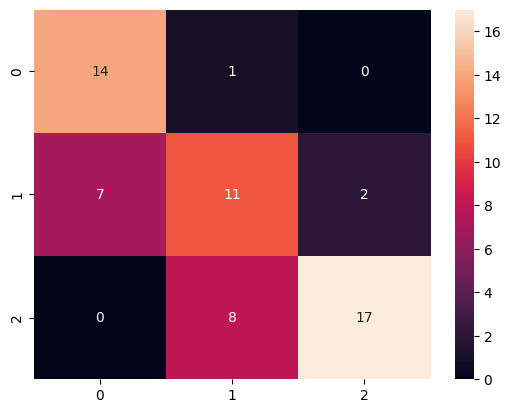

In [22]:
test_acc, probabilities, labels = test(model_tl, test_loader, device)
print("Average accuracy in the whole test data:")
print(test_acc.item()) 

test_labels, pred_labels = [], []

# Appending the test labels
for label in labels:
    test_labels.append(label.item())  

# Getting the predicted label from the from the category with the highest probability
for prob in probabilities:
    pred_labels.append(np.argmax(prob))

cm = confusion_matrix(test_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='g')

**Images misclassified**

9


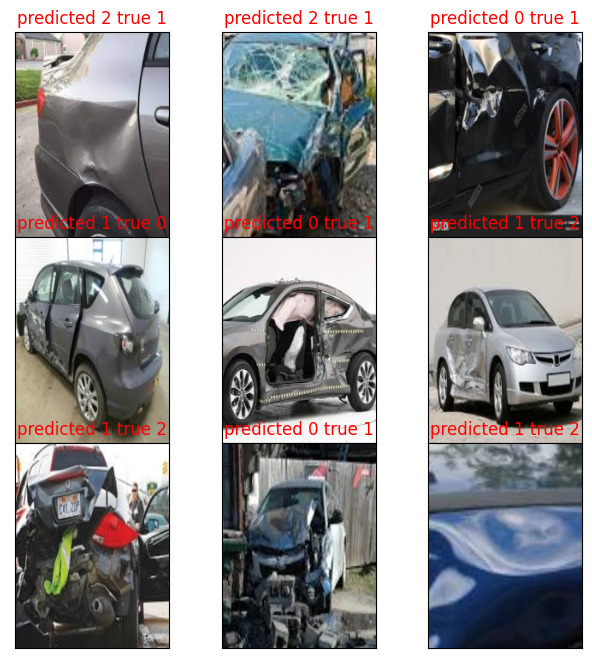

In [67]:
k = 0
wrong_labs = []
img_list = []
title = []

for img, label in test_loader:
    if test_labels[k] != pred_labels[k]:
        wrong_labs.append((pred_labels[k], test_labels[k]))
        img = img.detach().cpu()
        img_list.append(img.reshape(img.shape[1:]))
    k += 1

for i in range(9):
    label = wrong_labs[i]
    title.append("predicted " + str(label[0]) + " true " + str(label[1]))
print(len(img_list[:9]))    
plot_image_batch(img_list[:9], title, size=3, figsize=(8, 8))

# Saving the model

In [20]:
modelo = ModelCars(model_tl, transformation_test, device)
torch.save(modelo, 'modelo.pth')

In [11]:
import torch
import matplotlib
import PIL

#Testing an image that it is not part of the dataset
test_image = PIL.Image.open('test-destructed.jpg')
model = torch.load('modelo.pth')
model.eval()
probs_test = model(test_image)
print(*probs_test.detach().cpu().numpy())

[0.06368038 0.19210158 0.744218  ]


c:\Users\danal\Desktop\insurance\PrimeAutoPredict\PrimeAutoPredict\CNN\model_functions.py:121: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x_shape = x.shape


In [1]:
from model_functions import predict

pred_cpu = predict('test-destructed.jpg')
print(pred_cpu)

2


c:\Users\danal\Desktop\insurance\PrimeAutoPredict\PrimeAutoPredict\CNN\model_functions.py:124: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)
